In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
!pip install pycountry
import pycountry

file_path = "Gov_Responses2Covid19_last.xlsx"
df = pd.read_excel(file_path, sheet_name="Dataset")


import pandas as pd

df['d'] = pd.to_datetime(df['d'])

# Forward-fill and backward-fill for categorical policy measures within each country
policy_cols = ['school', 'school_local', 'masks', 'masks_partial', 'domestic', 'domestic_local',
               'travel', 'travel_partial', 'travel_dom', 'travel_dom_partial', 'curf', 'curf_partial',
               'mass', 'mass_partial', 'elect', 'elect_partial', 'sport', 'sport_partial', 'rest',
               'rest_local', 'testing', 'testing_narrow', 'surveillance', 'surveillance_partial',
               'state', 'state_partial']

df[policy_cols] = df.groupby(['geoid', 'country'], group_keys=False)[policy_cols].apply(lambda group: group.ffill().bfill())

# Fill remaining missing policy values with 0 (assuming no policy intervention)
df[policy_cols] = df[policy_cols].fillna(0)

# Linear interpolation for economic measures within each country
economic_cols = ['wage', 'taxc', 'credit', 'cash', 'export', 'rate', 'Economic_Measures']
df[economic_cols] = df.groupby(['geoid', 'country'], group_keys=False)[economic_cols].apply(lambda group: group.interpolate(method='linear'))

# Fill remaining missing economic values with 0 (assuming no intervention)
df[economic_cols] = df[economic_cols].fillna(0)

# Rolling average for cases and deaths (7-day window)
df[['cases', 'deaths']] = df.groupby(['geoid', 'country'], group_keys=False)[['cases', 'deaths']].apply(
    lambda group: group.fillna(group.rolling(7, min_periods=1).mean())
)

# Fill remaining missing cases & deaths with 0
df[['cases', 'deaths']] = df[['cases', 'deaths']].fillna(0)

# Drop election-related variables (optional)
df.drop(columns=['elect', 'elect_partial'], errors='ignore', inplace=True)

# Mean imputation for population within the same continent
df['population_2019'] = df.groupby('continent')['population_2019'].transform(lambda x: x.fillna(x.mean()))

# Fill missing continent values using most frequent value (mode)
df['continent'].fillna(df['continent'].mode()[0], inplace=True)

# Fill missing geoid with country ISO code (if applicable)
df['geoid'].fillna(df['iso'], inplace=True)

df['taxd'].fillna(0, inplace=True)
df['Rigidity_Public_Health'].fillna(0, inplace=True)

# Fill remaining missing population with global mean
df['population_2019'].fillna(df['population_2019'].mean(), inplace=True)

# Ensure index alignment
df.reset_index(drop=True, inplace=True)

# Check missing values again
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# PLOTTING

# First, let's prepare the data for geographical analysis
def prepare_geo_data(df):
    # Aggregate data by country
    country_data = df.groupby('country').agg({
        'cases': 'sum',
        'deaths': 'sum',
        'Rigidity_Public_Health': 'mean',
        'Economic_Measures': 'mean',
        'continent': 'first',  # Get the continent for each country
        'population_2019': 'first'  # Get population data
    }).reset_index()

    # Calculate per capita metrics
    country_data['cases_per_million'] = (country_data['cases'] / country_data['population_2019']) * 1000000
    country_data['deaths_per_million'] = (country_data['deaths'] / country_data['population_2019']) * 1000000

    # Map country names to ISO codes for mapping
    country_data['iso_alpha'] = country_data['country'].apply(get_country_code)

    return country_data

# Function to get country ISO codes
def get_country_code(country_name):
    try:
        # Handle special cases
        if country_name == "USA":
            return "USA"
        elif country_name == "UK":
            return "GBR"
        elif country_name == "Russia":
            return "RUS"
        elif country_name == "South Korea":
            return "KOR"

        # Try to find the country
        country = pycountry.countries.get(name=country_name)
        if country:
            return country.alpha_3

        # Try to find by fuzzy matching
        countries = pycountry.countries.search_fuzzy(country_name)
        if countries:
            return countries[0].alpha_3
    except:
        return None
    return None

# Create a world map of COVID-19 cases
def plot_cases_map(country_data):
    # Create figure for cases per million
    fig_cases = px.choropleth(
        country_data,
        locations="iso_alpha",
        color="cases_per_million",
        hover_name="country",
        hover_data=["cases", "deaths", "cases_per_million", "deaths_per_million"],
        color_continuous_scale=px.colors.sequential.Plasma,
        title="COVID-19 Cases per Million by Country",
        labels={"cases_per_million": "Cases per Million"}
    )

    fig_cases.update_layout(
        geo=dict(
            showframe=False,
            showcoastlines=True,
            projection_type='natural earth'
        ),
        height=700,
        margin={"r":0,"t":50,"l":0,"b":0}
    )

    # Create figure for total cases (log scale for better visualization)
    fig_total = px.choropleth(
        country_data,
        locations="iso_alpha",
        color=np.log10(country_data["cases"] + 1),  # Log scale to better show distribution
        hover_name="country",
        hover_data=["cases", "deaths", "continent"],
        color_continuous_scale=px.colors.sequential.Viridis,
        title="Total COVID-19 Cases by Country (Log Scale)",
        labels={"color": "Log10(Cases)"}
    )

    fig_total.update_layout(
        geo=dict(
            showframe=False,
            showcoastlines=True,
            projection_type='natural earth'
        ),
        height=700,
        margin={"r":0,"t":50,"l":0,"b":0}
    )

    return fig_cases, fig_total

# Create maps for policy metrics
def plot_policy_maps(country_data):
    # Create figure for Public Health Rigidity
    fig_health = px.choropleth(
        country_data,
        locations="iso_alpha",
        color="Rigidity_Public_Health",
        hover_name="country",
        hover_data=["Rigidity_Public_Health", "cases_per_million", "deaths_per_million"],
        color_continuous_scale=px.colors.sequential.Blues,
        title="Public Health Measures Rigidity by Country",
        labels={"Rigidity_Public_Health": "Health Measure Rigidity"}
    )

    fig_health.update_layout(
        geo=dict(
            showframe=False,
            showcoastlines=True,
            projection_type='natural earth'
        ),
        height=700,
        margin={"r":0,"t":50,"l":0,"b":0}
    )

    # Create figure for Economic Measures
    fig_econ = px.choropleth(
        country_data,
        locations="iso_alpha",
        color="Economic_Measures",
        hover_name="country",
        hover_data=["Economic_Measures", "cases_per_million", "deaths_per_million"],
        color_continuous_scale=px.colors.sequential.Greens,
        title="Economic Support Measures by Country",
        labels={"Economic_Measures": "Economic Support"}
    )

    fig_econ.update_layout(
        geo=dict(
            showframe=False,
            showcoastlines=True,
            projection_type='natural earth'
        ),
        height=700,
        margin={"r":0,"t":50,"l":0,"b":0}
    )

    return fig_health, fig_econ

# Create a continental analysis - average cases and policies by continent
def continental_analysis(country_data):
    # Aggregate by continent
    continent_data = country_data.groupby('continent').agg({
        'cases': 'sum',
        'deaths': 'sum',
        'population_2019': 'sum',
        'Rigidity_Public_Health': 'mean',
        'Economic_Measures': 'mean'
    }).reset_index()

    # Calculate per capita metrics by continent
    continent_data['cases_per_million'] = (continent_data['cases'] / continent_data['population_2019']) * 1000000
    continent_data['deaths_per_million'] = (continent_data['deaths'] / continent_data['population_2019']) * 1000000

    # Create subplots for continental analysis
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            "Cases per Million by Continent",
            "Total Cases by Continent",
            "Public Health Measures by Continent",
            "Economic Support by Continent"
        ],
        specs=[[{"type": "bar"}, {"type": "bar"}],
               [{"type": "bar"}, {"type": "bar"}]]
    )

    # Cases per million
    fig.add_trace(
        go.Bar(
            x=continent_data['continent'],
            y=continent_data['cases_per_million'],
            marker_color='purple',
            name='Cases per Million'
        ),
        row=1, col=1
    )

    # Total cases
    fig.add_trace(
        go.Bar(
            x=continent_data['continent'],
            y=continent_data['cases'],
            marker_color='blue',
            name='Total Cases'
        ),
        row=1, col=2
    )

    # Public Health Measures
    fig.add_trace(
        go.Bar(
            x=continent_data['continent'],
            y=continent_data['Rigidity_Public_Health'],
            marker_color='green',
            name='Health Measures'
        ),
        row=2, col=1
    )

    # Economic Measures
    fig.add_trace(
        go.Bar(
            x=continent_data['continent'],
            y=continent_data['Economic_Measures'],
            marker_color='orange',
            name='Economic Support'
        ),
        row=2, col=2
    )

    fig.update_layout(
        height=800,
        title_text="COVID-19 Analysis by Continent",
        showlegend=False
    )

    return fig

# Create heatmap comparing policy and cases/deaths by continent
def continental_policy_impact(country_data):
    # Create pivot table for heatmap
    continent_pivot = country_data.pivot_table(
        index='continent',
        values=['cases_per_million', 'deaths_per_million', 'Rigidity_Public_Health', 'Economic_Measures'],
        aggfunc='mean'
    )

    # Create heatmap
    fig = px.imshow(
        continent_pivot,
        labels=dict(x="Metric", y="Continent", color="Value"),
        x=continent_pivot.columns,
        y=continent_pivot.index,
        color_continuous_scale='RdBu_r',
        title="COVID-19 Metrics by Continent (Z-Score Normalized)",
        aspect="auto",
        zmin=-2,
        zmax=2
    )

    fig.update_layout(height=600)

    return fig

# Let's create a comprehensive geographic analysis function
def geographical_analysis(df):
    # Prepare the data
    country_data = prepare_geo_data(df)

    # Create the maps
    fig_cases_per_million, fig_total_cases = plot_cases_map(country_data)
    fig_health_policy, fig_economic_policy = plot_policy_maps(country_data)

    # Create continent analysis
    fig_continent = continental_analysis(country_data)
    fig_continent_heatmap = continental_policy_impact(country_data)

    # Return all figures
    return {
        'cases_per_million': fig_cases_per_million,
        'total_cases': fig_total_cases,
        'health_policy': fig_health_policy,
        'economic_policy': fig_economic_policy,
        'continent_analysis': fig_continent,
        'continent_heatmap': fig_continent_heatmap
    }

# Main execution function
def run_geographical_analysis(df):
    # Make sure we have the right columns
    required_columns = ['country', 'cases', 'deaths', 'Rigidity_Public_Health',
                        'Economic_Measures', 'continent', 'population_2019']

    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        print(f"Warning: Missing columns: {missing_columns}")
        print("Available columns:", df.columns.tolist())
        print("Creating dummy columns for missing data...")

        # Create dummy columns for any missing data
        for col in missing_columns:
            if col == 'Rigidity_Public_Health' and col not in df.columns:
                # Try to find alternative policy columns
                policy_cols = [c for c in df.columns if any(p in c.lower() for p in ['policy', 'restrict', 'measure'])]
                if policy_cols:
                    print(f"Using {policy_cols[0]} as a proxy for Rigidity_Public_Health")
                    df['Rigidity_Public_Health'] = df[policy_cols[0]]
                else:
                    df['Rigidity_Public_Health'] = 0.5  # Default value

            elif col == 'Economic_Measures' and col not in df.columns:
                # Try to find alternative economic columns
                econ_cols = [c for c in df.columns if any(e in c.lower() for e in ['econom', 'support', 'relief'])]
                if econ_cols:
                    print(f"Using {econ_cols[0]} as a proxy for Economic_Measures")
                    df['Economic_Measures'] = df[econ_cols[0]]
                else:
                    df['Economic_Measures'] = 0.5  # Default value

            elif col == 'continent' and col not in df.columns:
                # Use a mapping function based on country
                df['continent'] = 'Unknown'  # Default value

            elif col == 'population_2019' and col not in df.columns:
                # Default population
                df['population_2019'] = 1000000  # Default value

    # Run the analysis
    figures = geographical_analysis(df)

    # Show the figures
    for name, fig in figures.items():
        print(f"Displaying {name.replace('_', ' ')} visualization...")
        fig.show()

    return figures

# Example usage
run_geographical_analysis(df)

<ipython-input-9-95e17ebcb72d>:53: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-9-95e17ebcb72d>:56: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

Series([], dtype: int64)
Displaying cases per million visualization...


Displaying total cases visualization...


Displaying health policy visualization...


Displaying economic policy visualization...


Displaying continent analysis visualization...


Displaying continent heatmap visualization...


{'cases_per_million': Figure({
     'data': [{'coloraxis': 'coloraxis',
               'customdata': array([[3.92680000e+04, 1.45800000e+03, 1.03336842e+03, 3.83684211e+01],
                                    [1.36490000e+04, 3.87000000e+02, 4.70655172e+03, 1.33448276e+02],
                                    [5.15300000e+04, 1.73400000e+03, 1.19837209e+03, 4.03255814e+01],
                                    ...,
                                    [2.03500000e+03, 5.88000000e+02, 7.01724138e+01, 2.02758621e+01],
                                    [1.47590000e+04, 3.32000000e+02, 8.19944444e+02, 1.84444444e+01],
                                    [7.83800000e+03, 2.28000000e+02, 5.22533333e+02, 1.52000000e+01]]),
               'geo': 'geo',
               'hovertemplate': ('<b>%{hovertext}</b><br><br>iso' ... '{customdata[3]}<extra></extra>'),
               'hovertext': array(['Afghanistan', 'Albania', 'Algeria', ..., 'Yemen', 'Zambia', 'Zimbabwe'],
                              

Unique Countries: 228
Unique Continents: 5


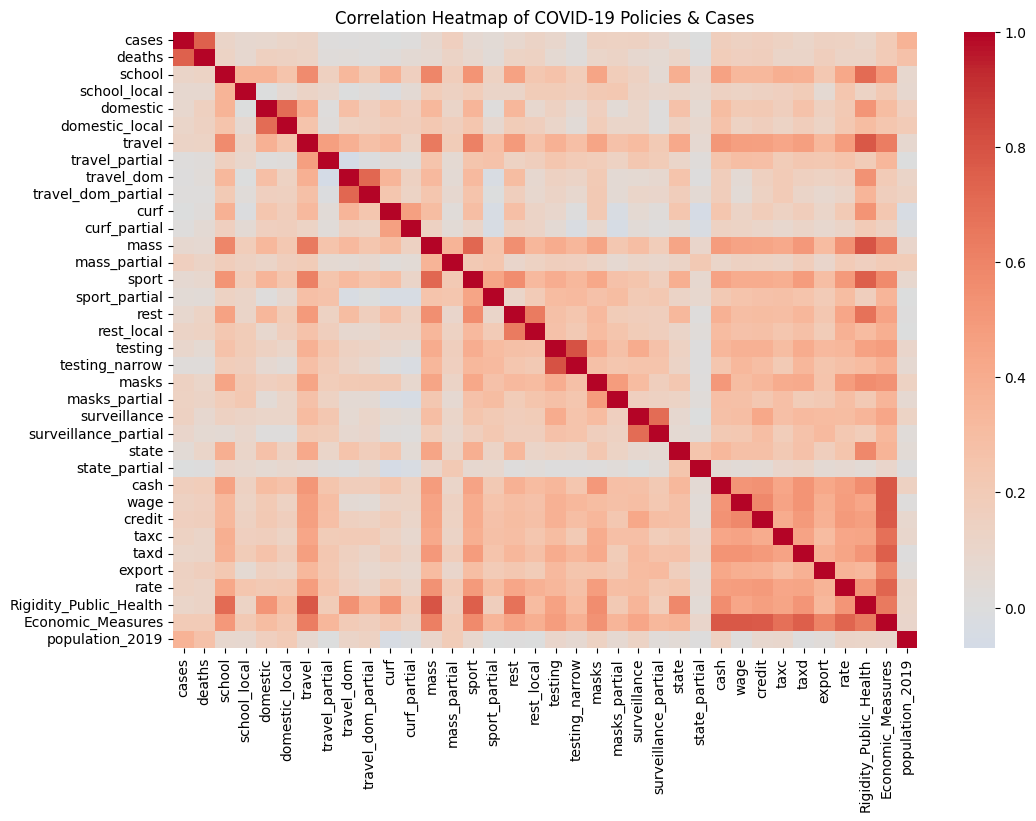

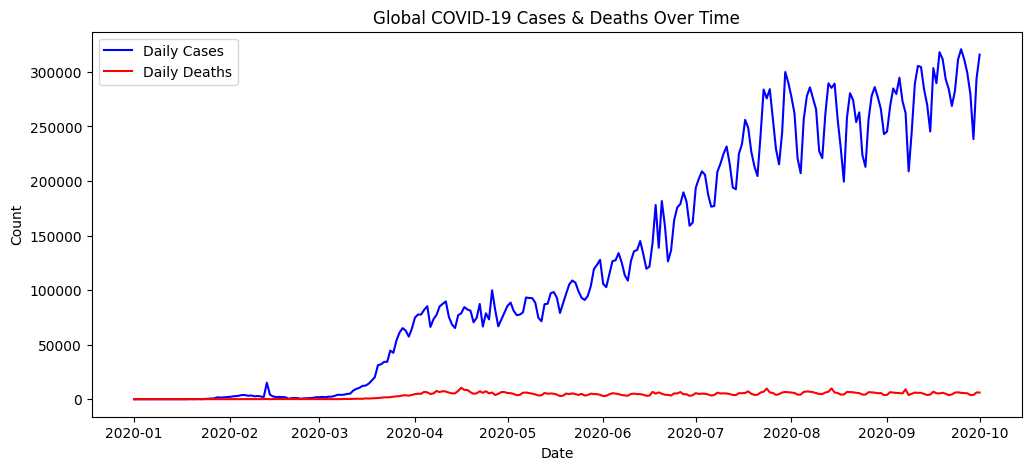

TypeError: Data source must be a DataFrame or Mapping, not <class 'pandas.core.series.Series'>.

<Figure size 1200x500 with 0 Axes>

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Count unique values in categorical columns
print("Unique Countries:", df['country'].nunique())
print("Unique Continents:", df['continent'].nunique())

numeric_df = df.select_dtypes(include=[np.number])

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of COVID-19 Policies & Cases")
plt.show()


# COVID-19 Cases & Deaths Over Time
global_trends = df.groupby("d")[["cases", "deaths"]].sum()
plt.figure(figsize=(12, 5))
sns.lineplot(data=global_trends, x=global_trends.index, y="cases", label="Daily Cases", color="blue")
sns.lineplot(data=global_trends, x=global_trends.index, y="deaths", label="Daily Deaths", color="red")
plt.title("Global COVID-19 Cases & Deaths Over Time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.show()

# Policy Response Over Time
policy_trends = df.groupby("d")["Rigidity_Public_Health"].mean()
plt.figure(figsize=(12, 5))
sns.lineplot(data=policy_trends, x=policy_trends.index, y=policy_trends, label="Policy Stringency Index", color="green")
plt.title("Global Government Policy Stringency Over Time")
plt.xlabel("Date")
plt.ylabel("Stringency Index")
plt.show()

# Clustering Countries Based on Response Strategies
cluster_features = df.groupby("country")[["Rigidity_Public_Health", "Economic_Measures"]].mean()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_features["Cluster"] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cluster_features, x="Rigidity_Public_Health", y="Economic_Measures", hue="Cluster", palette="viridis")
plt.title("Clustering Countries Based on COVID-19 Response Strategies")
plt.xlabel("Public Health Rigidity")
plt.ylabel("Economic Measures")
plt.show()
